### Import necessary libraries. 

In [1]:
# Data processing modual
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE # Oversampling
from collections import OrderedDict

# Visualisation modual
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

# Machine Learning Modual
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

### Read data file

In [2]:
#sets the maximum number of columns and rows displayed when a frame is pretty-printed
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [3]:
d = pd.read_csv('bankruptcy.csv')
#Replace the categorical column (class) values into binary
d['class']=pd.Categorical(d['class'].replace({"b'0'" : 0, "b'1'":1}))
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Attr1   10503 non-null  float64 
 1   Attr2   10503 non-null  float64 
 2   Attr3   10503 non-null  float64 
 3   Attr4   10485 non-null  float64 
 4   Attr5   10478 non-null  float64 
 5   Attr6   10503 non-null  float64 
 6   Attr7   10503 non-null  float64 
 7   Attr8   10489 non-null  float64 
 8   Attr9   10500 non-null  float64 
 9   Attr10  10503 non-null  float64 
 10  Attr11  10503 non-null  float64 
 11  Attr12  10485 non-null  float64 
 12  Attr13  10460 non-null  float64 
 13  Attr14  10503 non-null  float64 
 14  Attr15  10495 non-null  float64 
 15  Attr16  10489 non-null  float64 
 16  Attr17  10489 non-null  float64 
 17  Attr18  10503 non-null  float64 
 18  Attr19  10460 non-null  float64 
 19  Attr20  10460 non-null  float64 
 20  Attr21  9696 non-null   float64 
 21  Attr22  1050

In [4]:
# Change the class variable from categorical to integer
d['class']= pd.Categorical(d['class']).codes

In [5]:
def show_Null_plot(dataset):
    dataset.isnull().any() #check whether it is NULL for each row
    msno.matrix(dataset, labels = True, sparkline = False, figsize=(35,20), fontsize = 18)

Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr28     228
Attr53     228
Attr54     228
Attr64     228
Attr24     227
Attr41     202
Attr32     101
Attr47      86
Attr52      86
Attr30      43
Attr20      43
Attr49      43
Attr23      43
Attr56      43
Attr39      43
dtype: int64


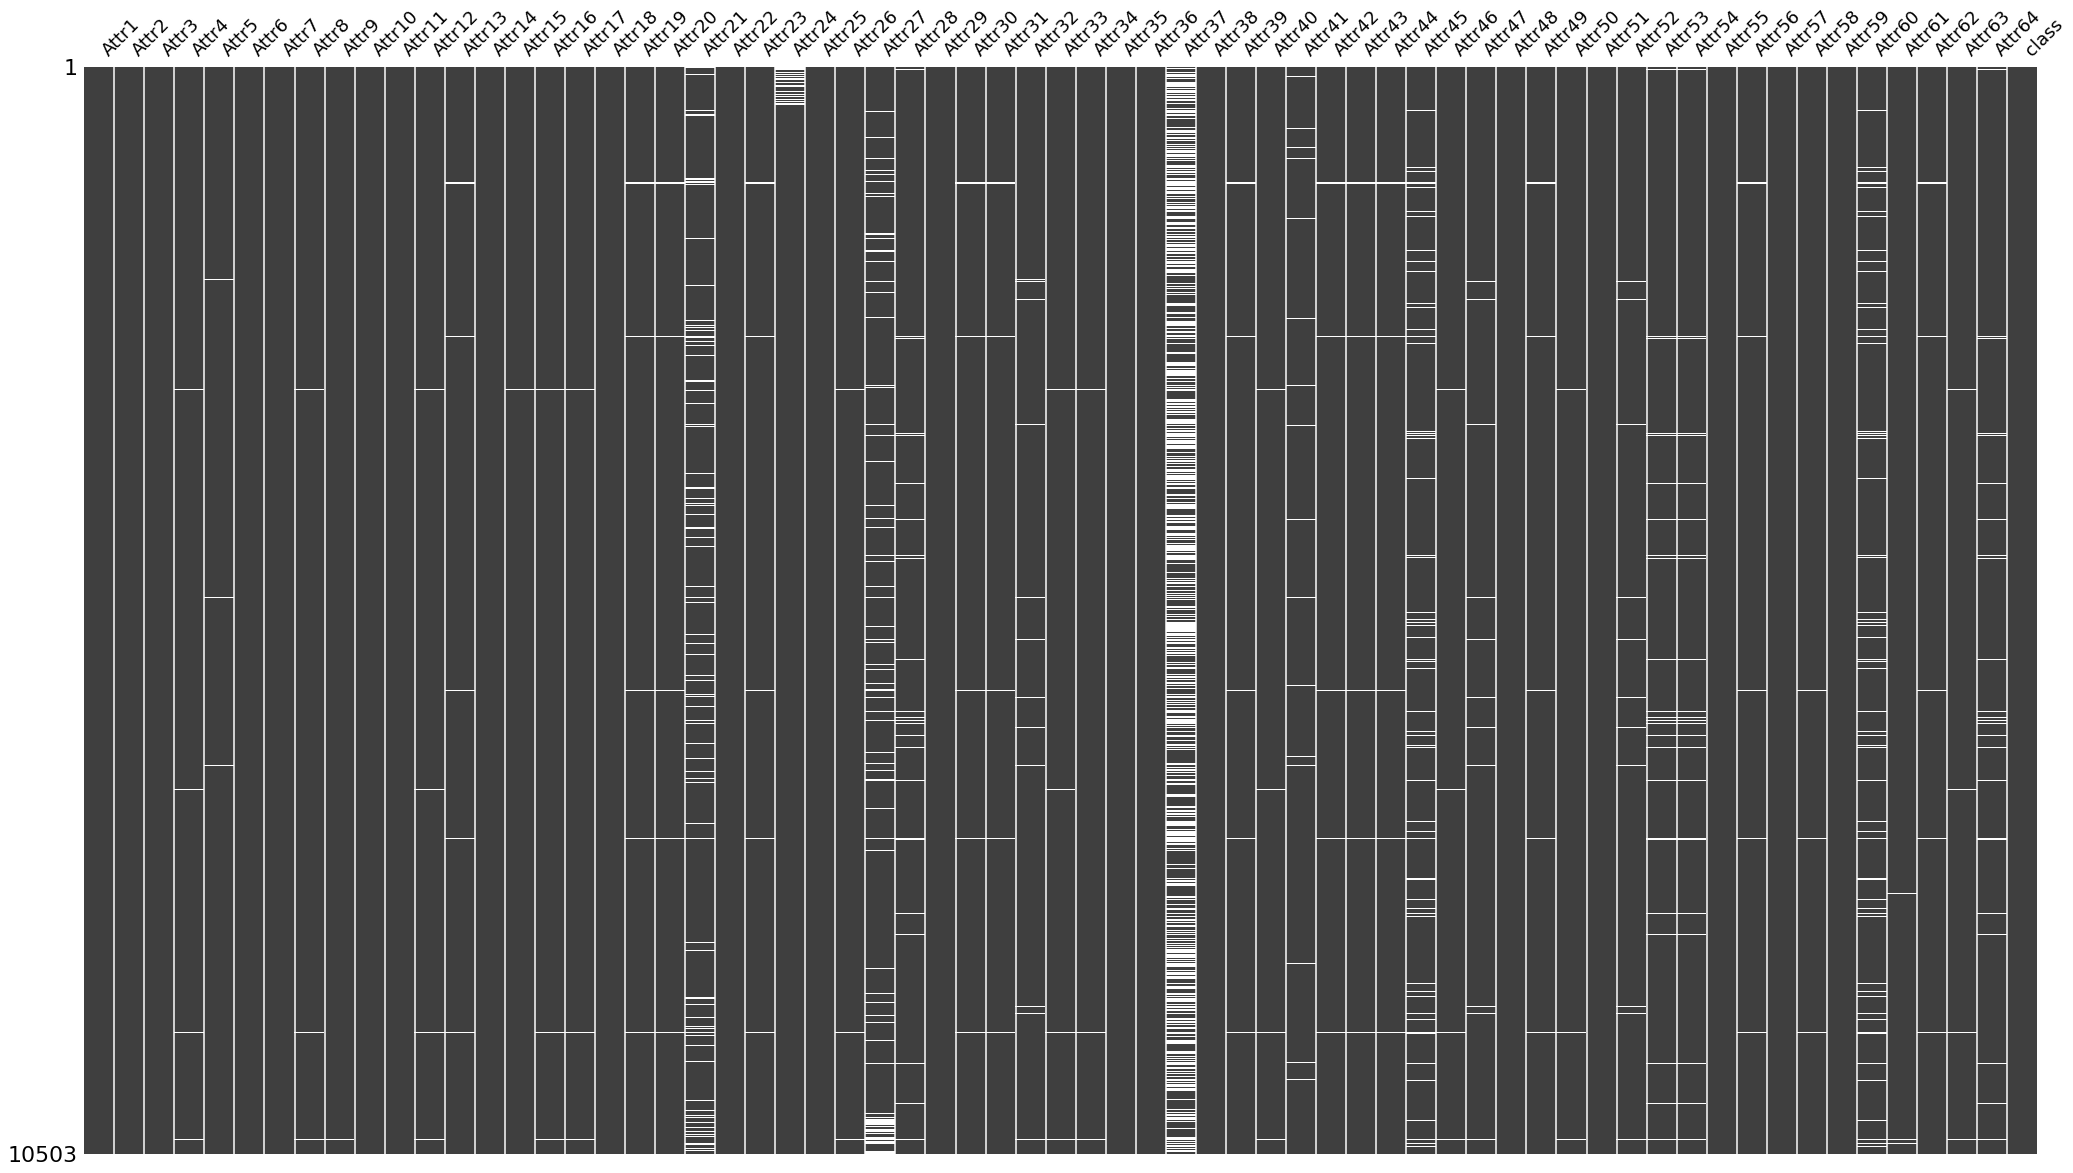

In [6]:
# Using opened-source to show the plot
show_Null_plot(d)

# Find top 20 columns with most null values
print(d.isnull().sum().sort_values(ascending=False).head(20))

<BarContainer object of 65 artists>

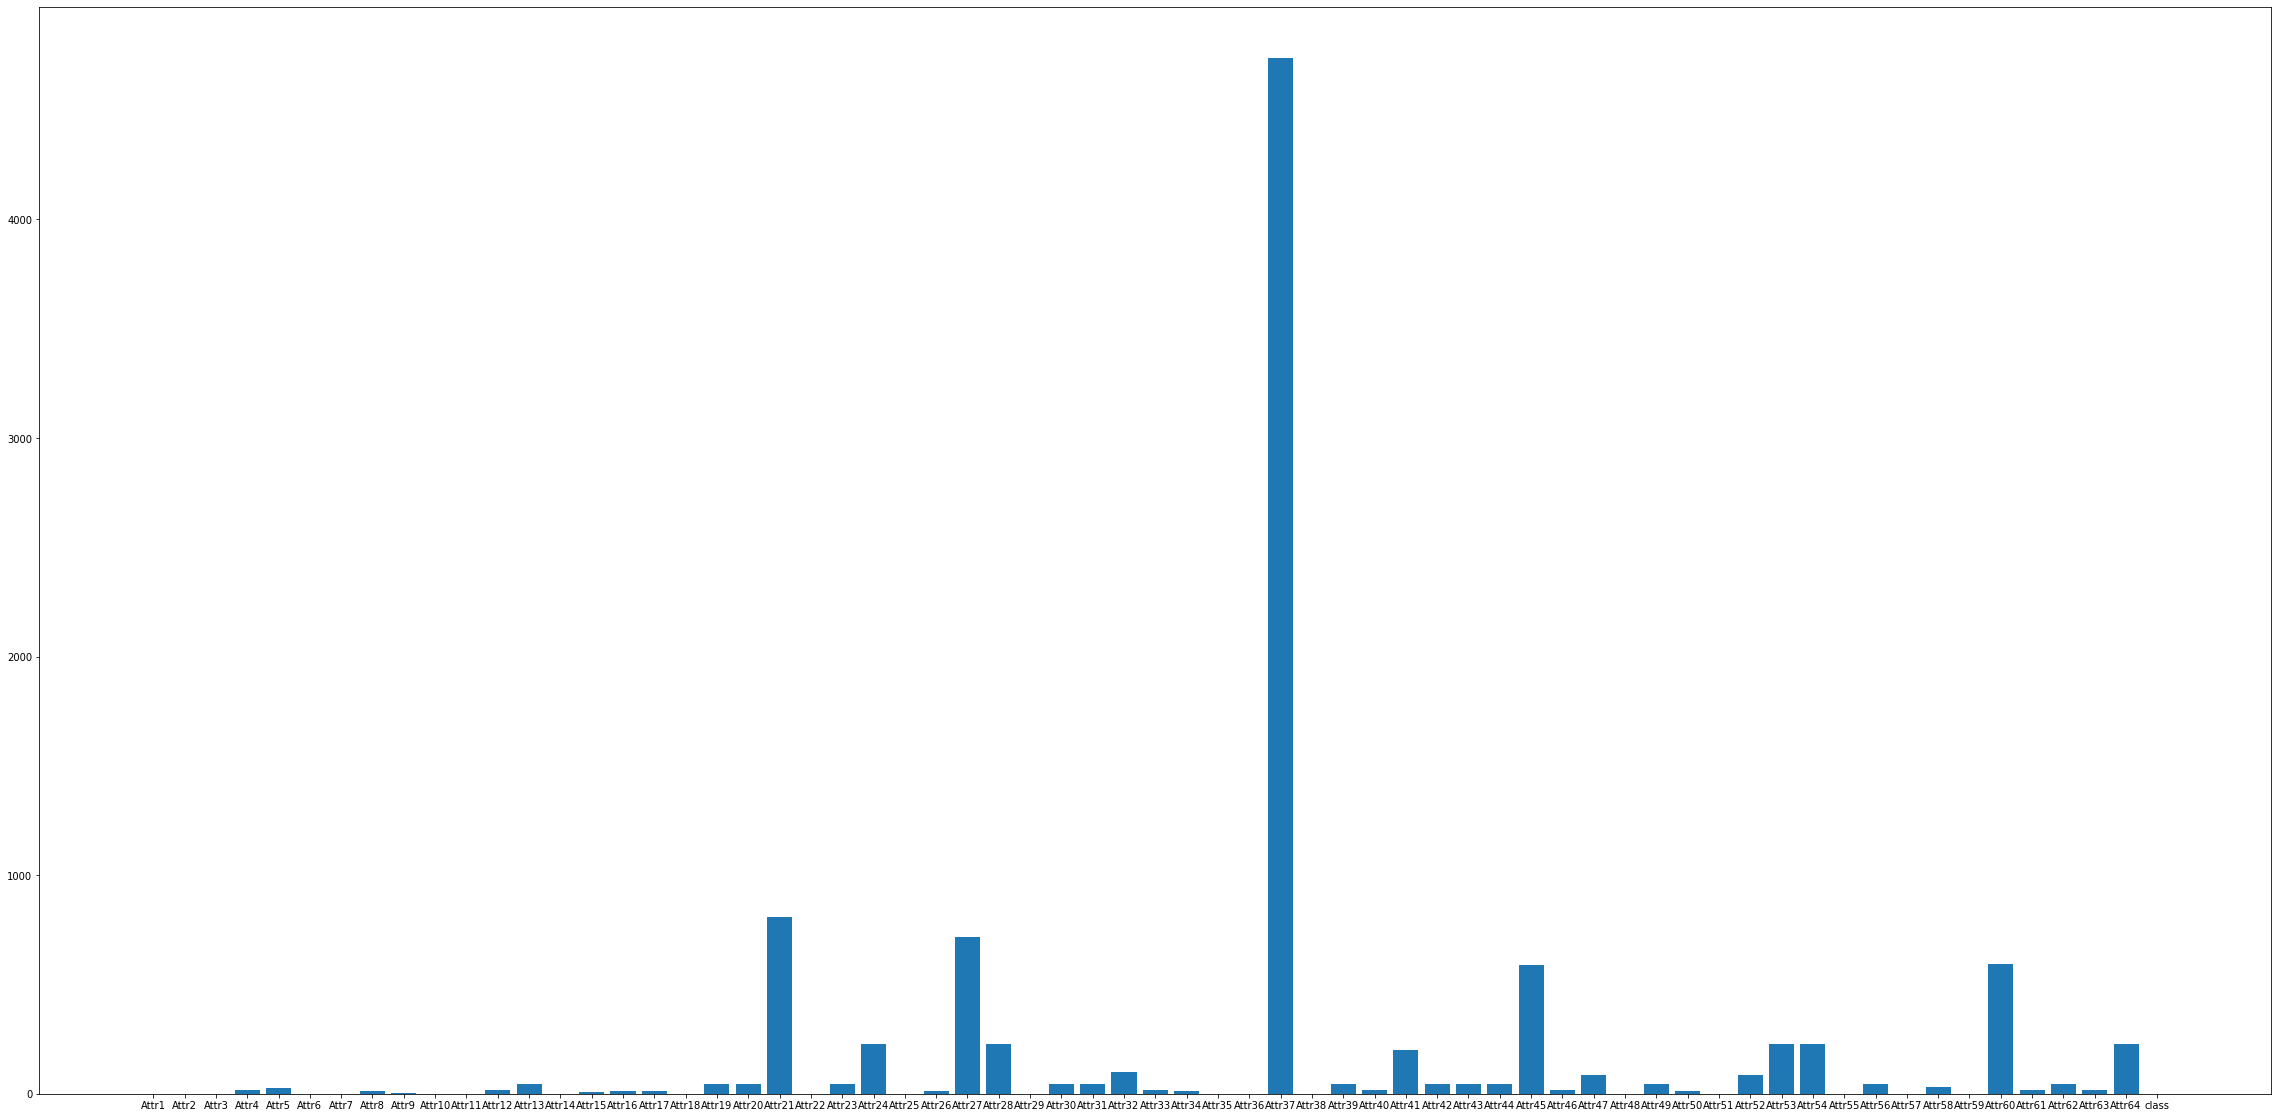

In [7]:
#replace the null values with 'nan'
d = d.replace('', np.nan)
nan_columns = []
nan_values = []
#count the number of  nan values in Dataset and plot a bargraph
for column in d.columns:
    nan_columns.append(column)
    nan_values.append(d[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

Column Attr37 contains the highest number of "Nan" values and data imputation on the column will nto be useful. Remove the column and plot the bar graph again

Attr21    807
Attr27    715
Attr60    592
Attr45    591
Attr64    228
Attr28    228
Attr54    228
Attr53    228
Attr24    227
Attr41    202
Attr32    101
Attr47     86
Attr52     86
Attr56     43
Attr23     43
Attr49     43
Attr19     43
Attr20     43
Attr39     43
Attr31     43
dtype: int64


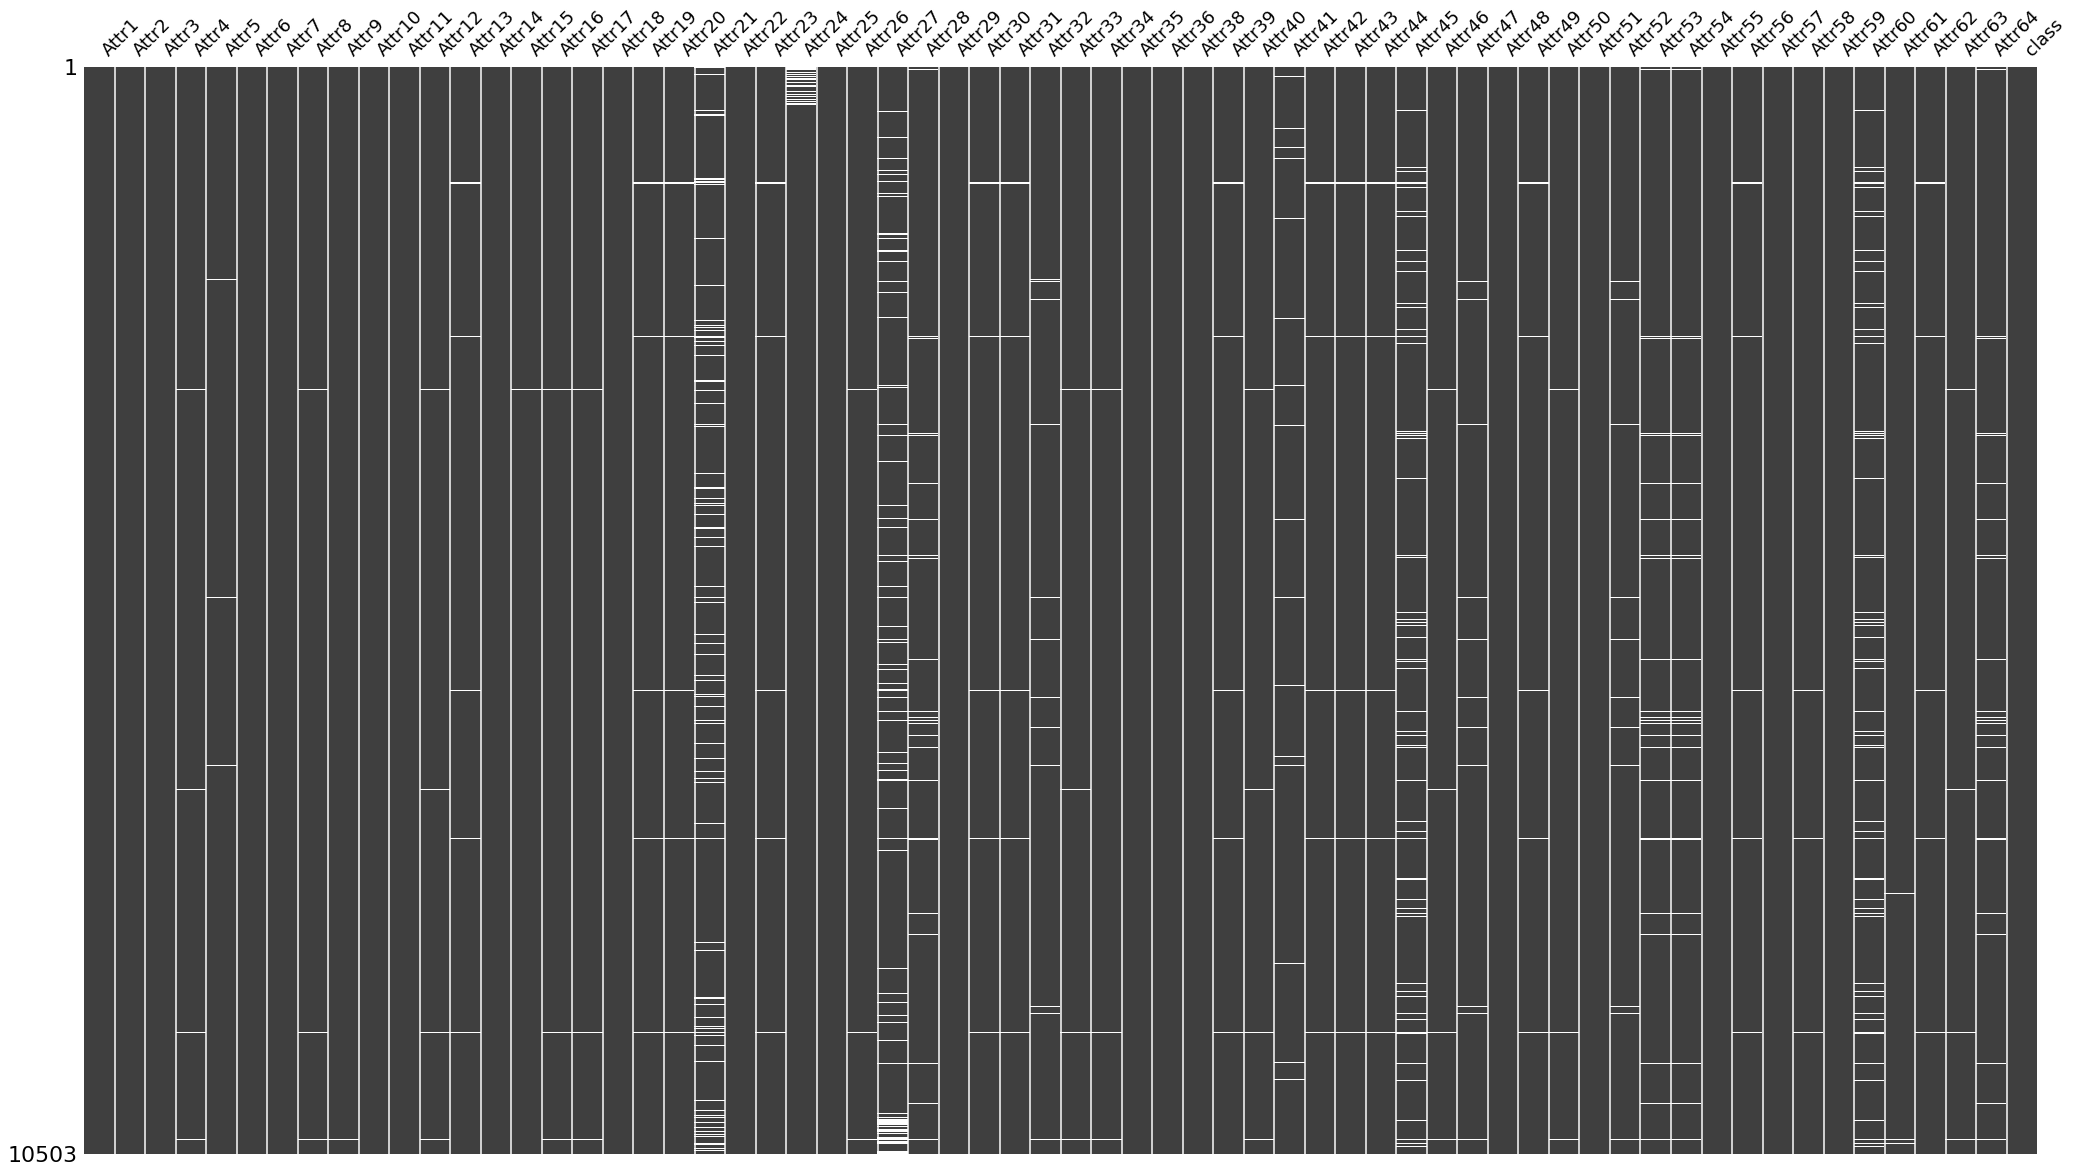

In [8]:
# Delete the column with highest number of nan values ie Column Attr37
d = d.drop(columns = ['Attr37'])
# Find 20 columns with most nan values
print(d.isnull().sum().sort_values(ascending=False).head(20))

show_Null_plot(d)

<BarContainer object of 64 artists>

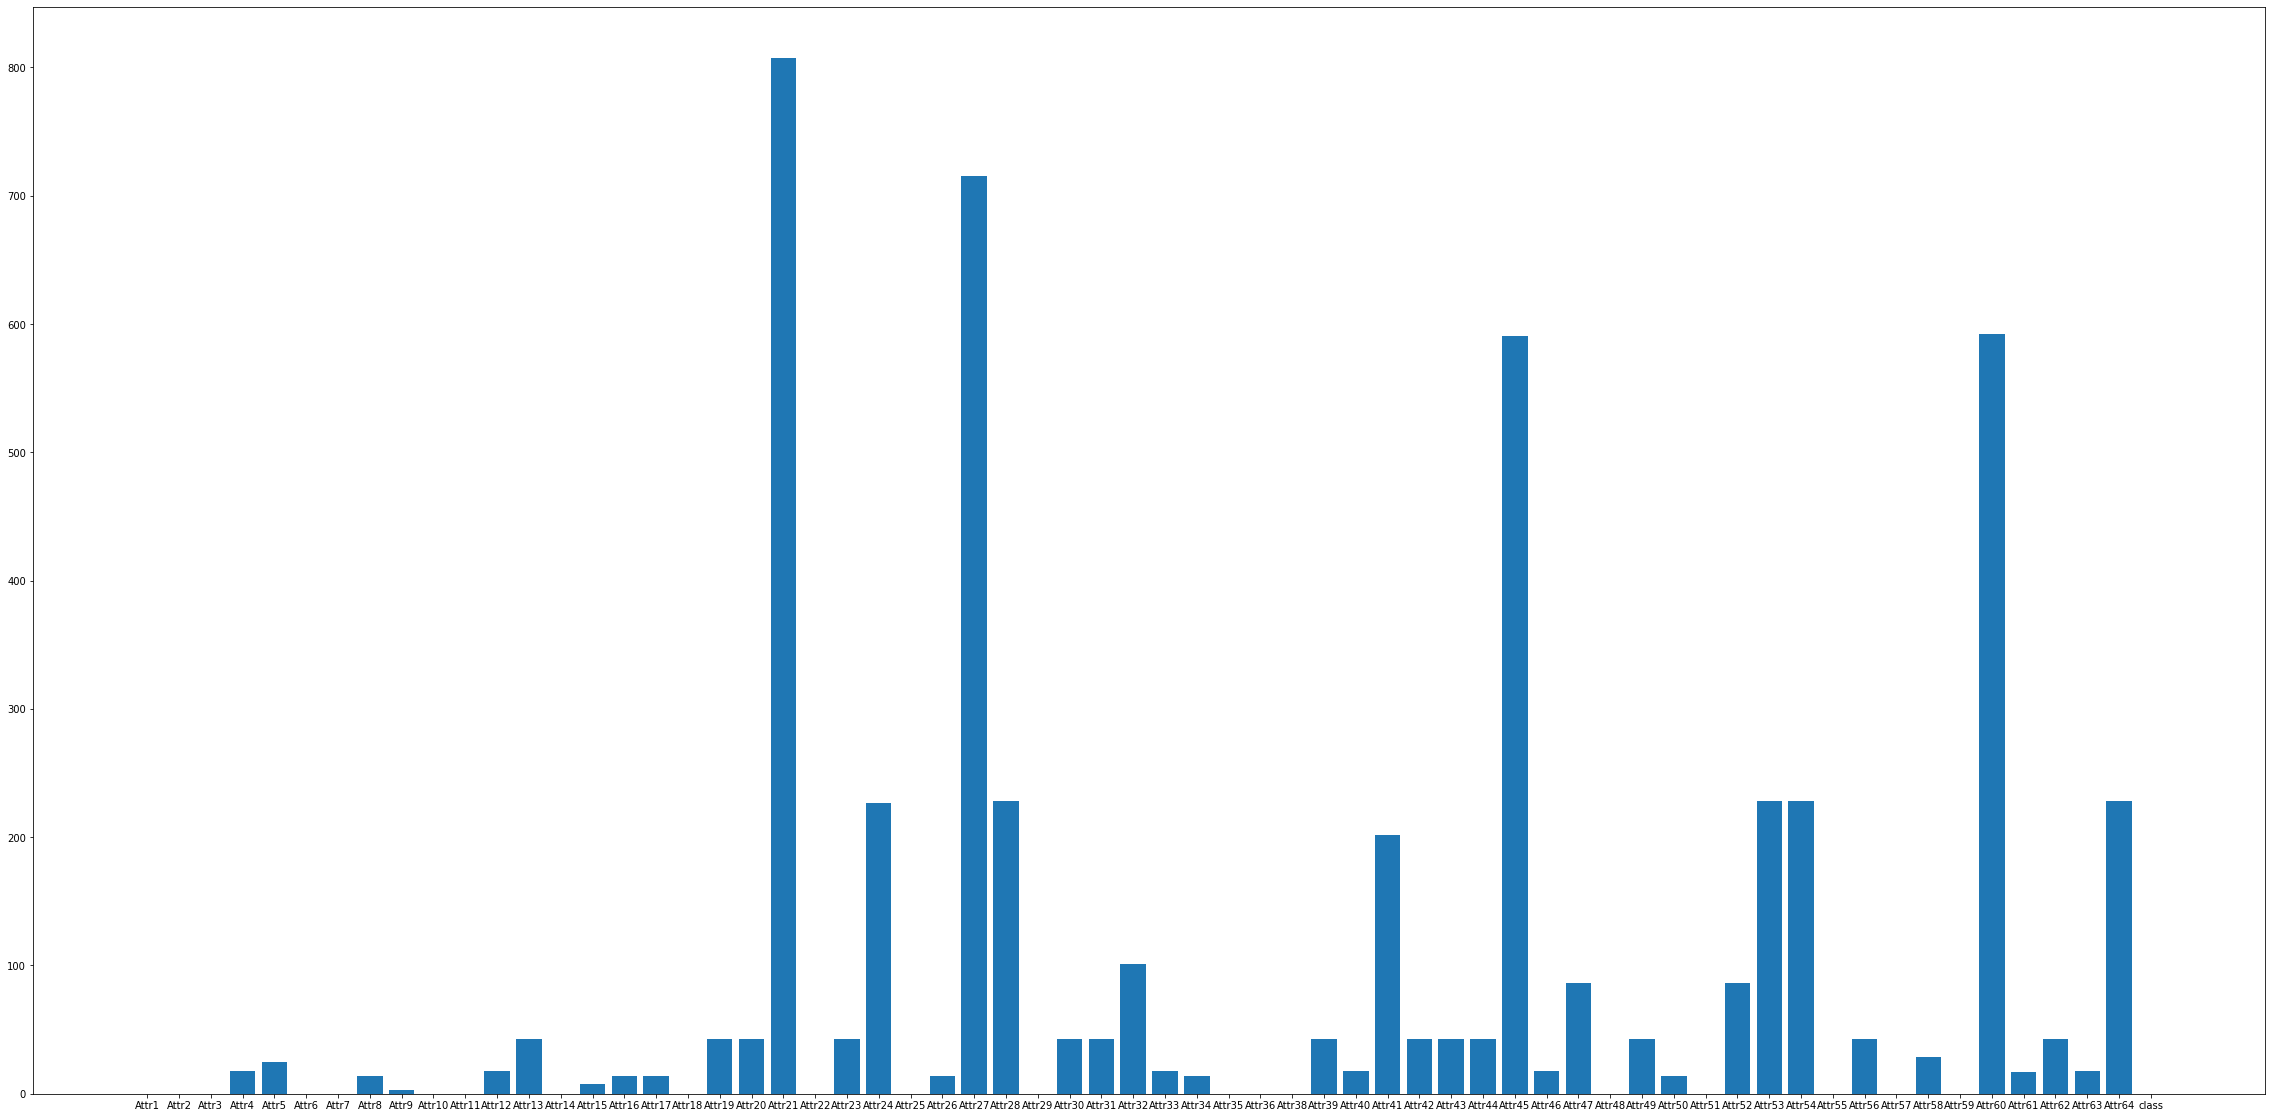

In [9]:
# Plot the null values graph after removing the Attr37 column
nan_columns = []
nan_values  = []

for column in d.columns:
    nan_columns.append(column)
    nan_values.append(d[column].isnull().sum())

fig, ax = plt.subplots(figsize=(40,20))
plt.bar(nan_columns, nan_values)

<AxesSubplot:xlabel='class', ylabel='count'>

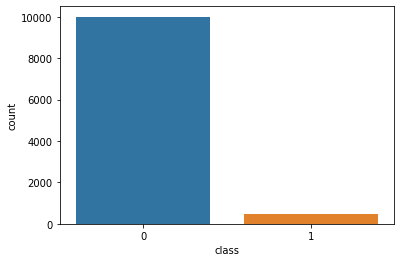

In [10]:
sns.countplot(x='class', data=d)

Sumamry - Data is <b>higly imbalance Data</b>

## Outlier detection & Treatment
Outliers are observations that are far away from the other data points in a random sample of a population. We often want to make assumptions about a specific population. Extreme values can have a significant impact on conclusions drawn from data.

<b>Commonly used methods for detection of outliers is:</b> 
1. Tukey’s box plot method-
    Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer       fence, whereas a probable outlier is located outside the outer fence.
2. z-score method-
    For each observation (Xn), it is measured how many standard deviations the data point is away from its mean (X̄).
3. Median Absolute Deviation method-
    Replaces the mean and standard deviation with more robust statistics, like the median and median absolute deviation. The       median absolute deviation is defined as:

In [14]:
# Method for outlier detection via Inter-quartile range method: 
def outlier_detection(x, scale):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - scale * IQR 
    upper = Q3 + scale * IQR  
    outliers = ((x<lower)| (x>upper)).sum()
    total_length = len(x.index)
    percent_outlier = (outliers * 100 / total_length).round(3)
    print(x.name, "\tTotal outliers is: ", outliers,"\t", "\t Percentage Outliers: ", percent_outlier )    

In [15]:
# check number of Outliers in all columns
# Scale is 1.5 (Popular)
scale = 1.5
for column in d:
    outlier_detection(d[column], scale)

Attr1 	Total outliers is:  1266 	 	 Percentage Outliers:  12.054
Attr2 	Total outliers is:  290 	 	 Percentage Outliers:  2.761
Attr3 	Total outliers is:  271 	 	 Percentage Outliers:  2.58
Attr4 	Total outliers is:  1113 	 	 Percentage Outliers:  10.597
Attr5 	Total outliers is:  1562 	 	 Percentage Outliers:  14.872
Attr6 	Total outliers is:  3170 	 	 Percentage Outliers:  30.182
Attr7 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr8 	Total outliers is:  1146 	 	 Percentage Outliers:  10.911
Attr9 	Total outliers is:  726 	 	 Percentage Outliers:  6.912
Attr10 	Total outliers is:  305 	 	 Percentage Outliers:  2.904
Attr11 	Total outliers is:  1012 	 	 Percentage Outliers:  9.635
Attr12 	Total outliers is:  1516 	 	 Percentage Outliers:  14.434
Attr13 	Total outliers is:  1100 	 	 Percentage Outliers:  10.473
Attr14 	Total outliers is:  1139 	 	 Percentage Outliers:  10.845
Attr15 	Total outliers is:  1799 	 	 Percentage Outliers:  17.128
Attr16 	Total outliers is:  1

<b>For the treatement of outliers there are several methods:</b>
1. Quantile-based Flooring and Capping:
    Here points below 10th percentile are replaced with 10th percentile values
    and  points above 90th percentile are replaced with 90th percentile values.
    
2. Trimming:
      We completely remove data points that are outliers. This changes the total number of data rows present largely for our         bankruptcy data
    
3. IQR Score:
    The rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed
    
4. Log Transformation:
    Each cell could be transformed to a new value by formulating logarithmic, square, square root etc. But since we have           negative values too we cannot use this method
    
5. Replacing Outliers with Median Values:
    We calculate the median and assign those values to the upper and lower datapoints

In [16]:
# Outlier treatment (Replacing Outliers with Median Values)
df_median_treated = d.copy()
def outlier_treatment(attr,threshold):
    Q1 = attr.quantile(0.25)
    Q2 = attr.quantile(0.50)
    Q3 = attr.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR 
    upper = Q3 + threshold * IQR 
    if (attr.name != 'class'):
        df_median_treated[attr.name] = np.where((df_median_treated[attr.name]>upper)|(df_median_treated[attr.name]<lower), Q2 , df_median_treated[attr.name]) 

In [17]:
for column in df_median_treated:
    outlier_treatment(df_median_treated[column], scale)
    
df_median_treated.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,10478.000000,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,10495.000000,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9788.000000,10275.000000,10503.000000,10460.000000,10460.000000,10402.000000,10485.000000,10489.000000,10503.000000,10503.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,10417.000000,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,10503.000000,10460.000000,10503.000000,10474.000000,10503.000000,9911.000000,10486.000000,10460.000000,10485.000000,10275.000000,10503.000000
mean,0.055132,0.471526,0.226989,1.797780,2.052617,0.008607,0.064839,1.379031,1.416955,0.512450,0.079971,0.201046,0.074509,0.064850,983.256606,0.278934,2.426973,0.064848,0.041018,38.388497,0.944285,0.068338,0.035532,0.185714,0.384008,0.252794,1.380672,0.574669,3.922662,0.230334,0.048461,83.343497,5.106519,2.499953,0.067020,1.673840,0.606513,0.043871,0.304956,0.093779,0.044558,101.126796,56.178645,0.331790,1.182433,41.497228,0.023854,0.014484,1.366370,0.355045,0.227819,1.281415,1.473313,1401.824380,0.060645,0.125739,0.943527,0.066428,11.426956,7.003060,76.024286,5.592025,4.759630,0.047129
std,0.087436,0.270816,0.287738,1.140869,70.153633,0.040741,0.100878,1.401404,0.712702,0.268852,0.107252,0.366147,0.077457,0.100873,1293.723823,0.368354,1.436500,0.100874,0.059989,30.815519,0.221717,0.101049,0.052322,0.252807,0.305054,0.335255,2.542282,0.884818,0.778408,0.232568,0.066150,52.247536,3.271502,2.570040,0.101575,0.887692,0.232288,0.062112,0.376925,0.106460,0.062394,50.268383,30.712851,0.593879,0.844468,33.968359,0.105885,0.066650,0.915897,0.225436,0.142702,0.935266,0.856059,2559.090079,0.085951,0.175138,0.082599,0.132909,8.651786,3.713534,47.596773,3.551275,4.099627,0.211926
min,-0.183050,0.000000,-0.583670,0.002080,-213.940000,-0.108380,-0.207790,-2.081800,-0.000084,-0.344980,-0.216090,-0.838260,-0.148340,-0.207790,-2801.200000,-0.813470,-0.043411,-0.207790,-0.126850,-0.001439,0.333360,-0.218350,-0.111910,-0.522850,-0.577780,-0.744590,-7.206000,-2.254000,1.816400,-0.454490,-0.138510,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.115510,-0.132440,-0.411990,-0.235740,-0.136930,-0.293730,0.000000,-1.406200,-0.079512,-17.303000,-0.273230,-0.179900,0.002080,0.000000,0.000000,-1.724500,-1.277400,-6486.200000,-0.181850,-0.389200,0.695110,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.008169,0.253955,0.038011,1.040100,-32.013250,0.000000,0.010156,0.431270,1.011375,0.322885,0.020209,0.019522,0.029676,0.010170,326.485000,0.070764,1.449200,0.010170,0.009075,14.253750,0.808110,0.000285,0.007697,0.031614,0.175565,0.065539,0.185785,0.056073,3.410800,0.083047,0.013559,44.725750,2.785900,0.374370,0.009312,1.043500,0.457290,0.008460,0.053764,0.034685,0.004648,65.649500,34.228750,0.043479,0.603040,14.941000,-0.028060,-0.014639,0.749370,0.177200,0.122530,0.715535,0.983205,100.370000,0.014210,0.027493,0.904880,0.000000,5.533150,4.487600,40.781750,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300,0.000000,0.050945,1.111000,1.199000,0.515500,0.068104,0.155880,0.066433,0.050953,805.690000,0.235140,2.152500,0.050953,0.032117,34.430750,0.955035,0.054633,0.027129,0.158370,0.377690,0.213260,1.066900,0.459930,3.932100,0.216525,0.039689,77.522000,4.680900,

In [18]:
df_median_treated.skew(axis = 0)

Attr1     0.292951
Attr2     0.395105
Attr3     0.083997
Attr4     1.372885
Attr5     0.060333
Attr6     1.932415
Attr7     0.284860
Attr8     1.495469
Attr9     1.034915
Attr10   -0.337776
Attr11    0.262639
Attr12    0.766119
Attr13    0.309812
Attr14    0.284659
Attr15    0.538153
Attr16    0.934837
Attr17    1.491486
Attr18    0.284722
Attr19    0.294779
Attr20    0.975859
Attr21    0.045587
Attr22    0.378081
Attr23    0.353005
Attr24    0.353357
Attr25   -0.330302
Attr26    0.895022
Attr27    1.315336
Attr28    1.197481
Attr29   -0.020777
Attr30    0.527366
Attr31    0.287743
Attr32    0.995194
Attr33    1.042976
Attr34    1.245447
Attr35    0.323601
Attr36    0.700900
Attr38   -0.586464
Attr39    0.332009
Attr40    1.903489
Attr41    0.673454
Attr42    0.363385
Attr43    0.600822
Attr44    0.639471
Attr45    0.677037
Attr46    1.386378
Attr47    1.018310
Attr48    0.215258
Attr49    0.090773
Attr50    1.359236
Attr51    0.687110
Attr52    0.993238
Attr53    0.978898
Attr54    1.

### Review Normal distribution Plots

In [19]:
#畫散點圖和直方圖
# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)  # 創建子圖1
# ax1.scatter(df_mean_imputed.index, df_mean_imputed['Attr57'])
# plt.grid()

# ax2 = fig.add_subplot(2,1,2)  # 創建子圖2
# df_mean_imputed['Attr57'].hist(bins=65,alpha = 0.5,ax = ax2)
# df_mean_imputed['Attr57'].plot(kind = 'kde', secondary_y=True,ax = ax2)
# plt.grid()

## Data Imputation

In [20]:
#Data imputation via mean on outlier treated data
d_imp1 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean') 
df_mean_imputed = pd.DataFrame(imp.fit_transform(d_imp1))
df_mean_imputed.rename(columns={i:d_imp1.columns[i] for i in range(d_imp1.columns.size)}, inplace = True)   
df_mean_imputed.describe().round(5) 

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79778,2.05262,0.00861,0.06484,1.37903,1.41695,0.51245,0.07997,0.20105,0.07451,0.06485,983.25661,0.27893,2.42697,0.06485,0.04102,38.38850,0.94428,0.06834,0.03553,0.18571,0.38401,0.25279,1.38067,0.57467,3.92266,0.23033,0.04846,83.34350,5.10652,2.49995,0.06702,1.67384,0.60651,0.04387,0.30496,0.09378,0.04456,101.12680,56.17865,0.33179,1.18243,41.49723,0.02385,0.01448,1.36637,0.35504,0.22782,1.28141,1.47331,1401.82438,0.06064,0.12574,0.94353,0.06643,11.42696,7.00306,76.02429,5.59203,4.75963,0.04713
std,0.08744,0.27082,0.28774,1.13989,70.07008,0.04074,0.10088,1.40047,0.71260,0.26885,0.10725,0.36583,0.07730,0.10087,1293.23098,0.36811,1.43554,0.10087,0.05987,30.75237,0.21303,0.10105,0.05221,0.25006,0.30505,0.33503,2.45421,0.87516,0.77841,0.23209,0.06601,51.99569,3.26870,2.56833,0.10158,0.88769,0.23229,0.06198,0.37660,0.10543,0.06227,50.16537,30.64991,0.57693,0.84374,33.82899,0.10589,0.06651,0.91529,0.22544,0.14212,0.92506,0.84672,2559.09008,0.08577,0.17514,0.08249,0.13291,8.40440,3.71053,47.49923,3.54823,4.05488,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43250,0.94428,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

In [21]:
df_mean_imputed.index

RangeIndex(start=0, stop=10503, step=1)

In [22]:
#Data imputation via median on outlier treated data
d_imp2 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'median') 
df_median_imputed= pd.DataFrame(imp.fit_transform(d_imp2))  # indexer method to update the dataframe
df_median_imputed.rename(columns={i:d_imp2.columns[i] for i in range(d_imp2.columns.size)}, inplace = True)
df_median_imputed.describe().round(5)       

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79745,2.05149,0.00861,0.06484,1.37867,1.41689,0.51245,0.07997,0.20097,0.07448,0.06485,983.12136,0.27888,2.42661,0.06485,0.04098,38.37229,0.94511,0.06834,0.03550,0.18512,0.38401,0.25274,1.35931,0.57218,3.92266,0.23028,0.04843,83.28752,5.10579,2.49936,0.06702,1.67384,0.60651,0.04383,0.30477,0.09350,0.04452,101.11863,56.17145,0.32782,1.18222,41.46126,0.02385,0.01445,1.36619,0.35504,0.22769,1.27969,1.47115,1401.82438,0.06061,0.12574,0.94355,0.06643,11.34383,7.00253,76.00234,5.59125,4.74443,0.04713
std,0.08744,0.27082,0.28774,1.13992,70.07009,0.04074,0.10088,1.40050,0.71261,0.26885,0.10725,0.36584,0.07730,0.10087,1293.24025,0.36811,1.43558,0.10087,0.05987,30.75341,0.21305,0.10105,0.05222,0.25009,0.30505,0.33503,2.45549,0.87532,0.77841,0.23209,0.06602,51.99879,3.26874,2.56838,0.10158,0.88769,0.23229,0.06199,0.37663,0.10545,0.06227,50.16553,30.65012,0.57716,0.84376,33.83131,0.10589,0.06652,0.91530,0.22544,0.14212,0.92513,0.84684,2559.09008,0.08578,0.17514,0.08249,0.13291,8.41128,3.71055,47.50046,3.54828,4.05617,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43075,0.95504,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

In [23]:
#Data imputation via mode on outlier treated data
d_imp3 = df_median_treated.copy()
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') 
df_freq_imputed = pd.DataFrame(imp.fit_transform(d_imp3))  # indexer method to update the dataframe
df_freq_imputed.rename(columns={i:d_imp3.columns[i] for i in range(d_imp3.columns.size)}, inplace = True)
df_freq_imputed.describe().round(5)          

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.05513,0.47153,0.22699,1.79745,2.05149,0.00861,0.06484,1.37867,1.41689,0.51245,0.07997,0.20097,0.07448,0.06485,983.12136,0.27888,2.42661,0.06485,0.04098,38.37230,0.94511,0.06834,0.03550,0.18512,0.38401,0.25274,1.35931,0.57218,3.92266,0.23028,0.04843,83.28752,5.10579,2.49936,0.06702,1.67384,0.60651,0.04383,0.30477,0.09350,0.04452,101.11863,56.17145,0.32782,1.18222,41.46126,0.02385,0.01445,1.36619,0.35504,0.22769,1.27969,1.47115,1401.82438,0.06061,0.12574,0.94355,0.06643,11.34383,7.00253,76.00234,5.59125,4.74443,0.04713
std,0.08744,0.27082,0.28774,1.13992,70.07009,0.04074,0.10088,1.40050,0.71261,0.26885,0.10725,0.36584,0.07730,0.10087,1293.24025,0.36811,1.43558,0.10087,0.05987,30.75341,0.21305,0.10105,0.05222,0.25009,0.30505,0.33503,2.45549,0.87532,0.77841,0.23209,0.06602,51.99879,3.26874,2.56838,0.10158,0.88769,0.23229,0.06199,0.37663,0.10545,0.06227,50.16553,30.65012,0.57716,0.84376,33.83131,0.10589,0.06652,0.91530,0.22544,0.14212,0.92513,0.84684,2559.09008,0.08578,0.17514,0.08249,0.13291,8.41128,3.71055,47.50046,3.54828,4.05617,0.21193
min,-0.18305,0.00000,-0.58367,0.00208,-213.94000,-0.10838,-0.20779,-2.08180,-0.00008,-0.34498,-0.21609,-0.83826,-0.14834,-0.20779,-2801.20000,-0.81347,-0.04341,-0.20779,-0.12685,-0.00144,0.33336,-0.21835,-0.11191,-0.52285,-0.57778,-0.74459,-7.20600,-2.25400,1.81640,-0.45449,-0.13851,-0.00225,-1.92190,-5.50250,-0.21367,-0.00008,-0.11551,-0.13244,-0.41199,-0.23574,-0.13693,-0.29373,0.00000,-1.40620,-0.07951,-17.30300,-0.27323,-0.17990,0.00208,0.00000,0.00000,-1.72450,-1.27740,-6486.20000,-0.18185,-0.38920,0.69511,-0.35181,0.00000,-0.01453,0.00000,-0.00016,-0.00010,0.00000
25%,0.00817,0.25396,0.03801,1.04090,-31.86650,0.00000,0.01016,0.43194,1.01145,0.32288,0.02021,0.01975,0.02992,0.01017,326.96000,0.07091,1.45035,0.01017,0.00916,14.40050,0.82428,0.00028,0.00781,0.03445,0.17556,0.06560,0.25186,0.06529,3.41080,0.08348,0.01365,45.13950,2.78970,0.37516,0.00931,1.04350,0.45729,0.00861,0.05389,0.03566,0.00481,65.80950,34.30700,0.05625,0.60394,15.14850,-0.02806,-0.01441,0.74981,0.17720,0.12342,0.72546,0.99278,100.37000,0.01434,0.02749,0.90513,0.00000,5.73430,4.49100,40.93850,3.06405,2.05560,0.00000
50%,0.04303,0.46414,0.19856,1.60560,1.57930,0.00000,0.05094,1.11100,1.19900,0.51550,0.06810,0.15588,0.06643,0.05095,805.69000,0.23514,2.15250,0.05095,0.03212,34.43250,0.95504,0.05463,0.02713,0.15837,0.37769,0.21326,1.06690,0.45993,3.93210,0.21652,0.03969,77.52200,4.68090,2.05160,0.05305,1.58690,0.62875,0.03408,0.19590,0.07913,0.03491,99.13100,54.42200,0.26127,1.06060,37.10400,0.00965,0.00603,1.23120,0.32657,0.21200,1.20180,1.37350,882.29000,0.05176,0.10688,0.95306,0.00298,9.95210,6.67730,70.66400,5.13920,4.05930,0.00000
75%,0.10102,0.66198,0.41938,2.19930,34.95150,0.00000,0.11948,1.81005,1.76155,0.72512,0.13874,0.

<AxesSubplot:>

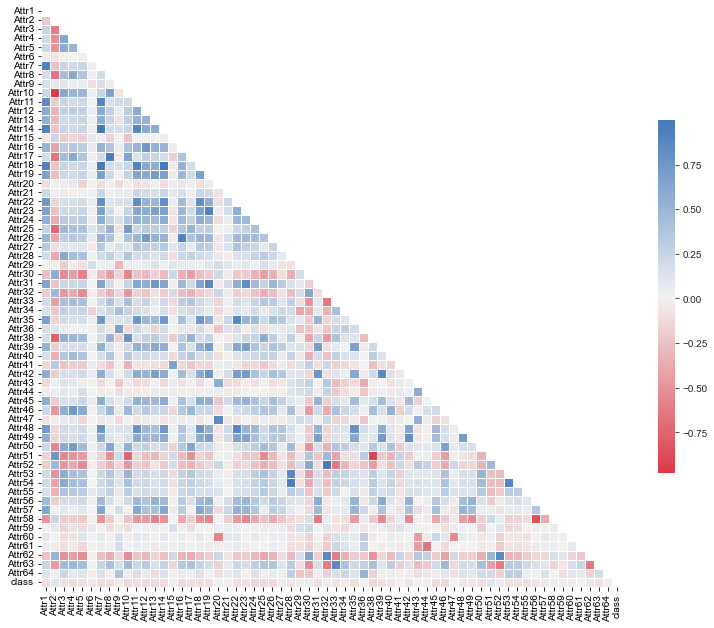

In [24]:
#Check Correlation matrix of mean imputed data
corr = df_mean_imputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 13))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,           #corr > 0.8 | corr < -0.8
            square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax , 
            xticklabels = df_mean_imputed.columns.tolist(),
            yticklabels = df_mean_imputed.columns.tolist()) 
           

<AxesSubplot:>

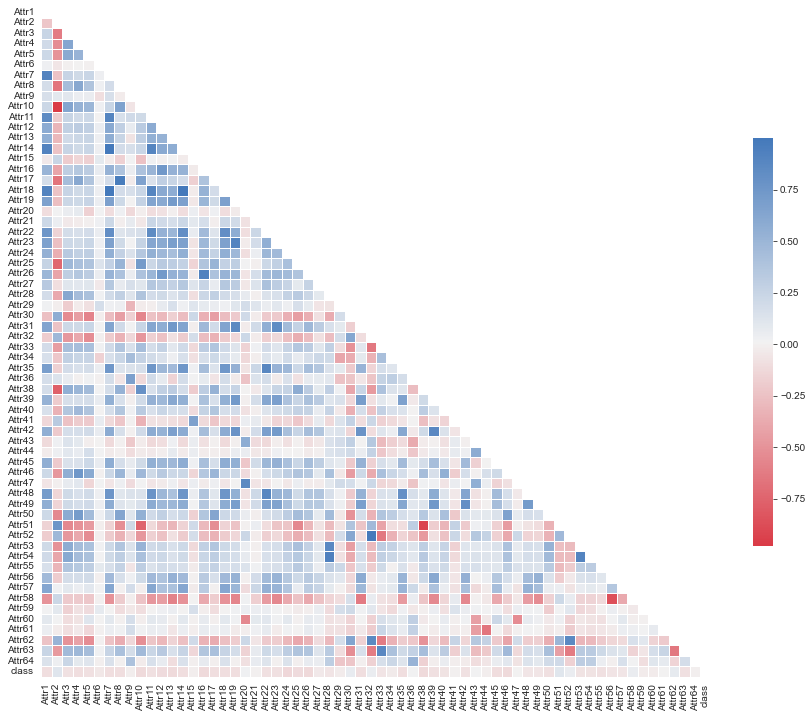

In [25]:
#Check Correlation matrix of median imputed data

corr_2 = df_median_imputed.corr()
mask = np.triu(np.ones_like(corr_2, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_2, mask=mask,
            cmap=cmap,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            ax= ax,
            xticklabels = df_median_imputed.columns.tolist(),
            yticklabels = df_median_imputed.columns.tolist())

In [26]:
# #histogram and normal probability plot
# sns.distplot(df_median_imputed['Attr29'], fit=norm);
# fig = plt.figure()
# res = stats.probplot(df_median_imputed['Attr29'], plot=plt)

<AxesSubplot:>

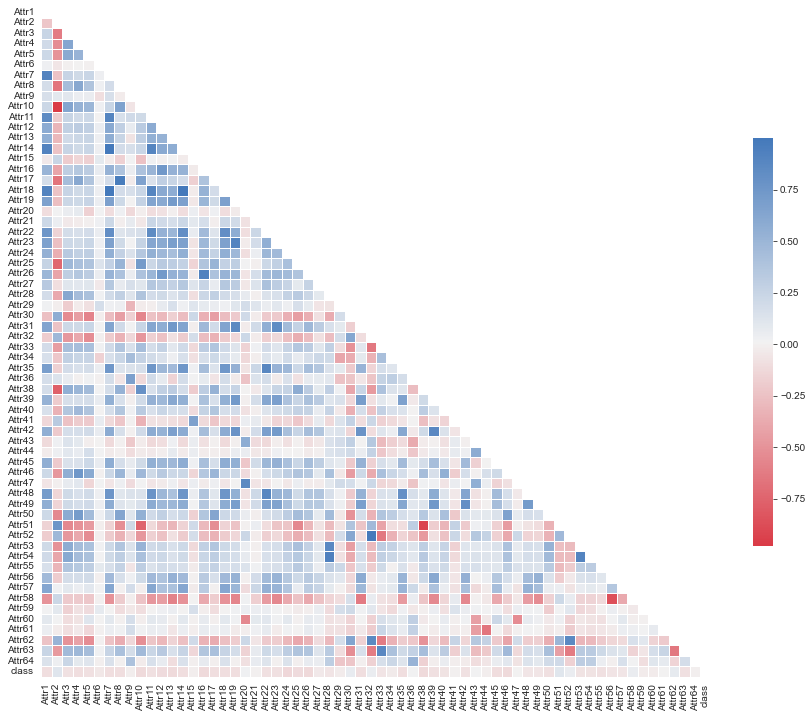

In [27]:
#Check Correlation matrix of mode imputed data

corr_3 = df_freq_imputed.corr()
mask = np.triu(np.ones_like(corr_3, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.set_style(style="white")
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_3, mask=mask, 
            cmap=cmap,
            square=True, 
            linewidths=.5,
            cbar_kws={"shrink": .5},
            ax= ax,
            xticklabels = df_freq_imputed.columns.tolist(),
            yticklabels = df_freq_imputed.columns.tolist())

Create the correlation groups and finalize the variables according to the groups

In [28]:
def correlation_group(correlation, percentile):
    correlation_pairs = correlation.unstack()
    high_correlation = correlation_pairs[(correlation_pairs>=percentile)|(correlation_pairs<= -1*percentile)]
    print(high_correlation)

In [29]:
correlation_group(corr_2 , 0.80)

Attr1   Attr1     1.000000
        Attr7     0.914111
        Attr11    0.850580
        Attr14    0.914053
        Attr18    0.914074
Attr2   Attr2     1.000000
        Attr10   -0.979433
Attr3   Attr3     1.000000
Attr4   Attr4     1.000000
Attr5   Attr5     1.000000
Attr6   Attr6     1.000000
Attr7   Attr1     0.914111
        Attr7     1.000000
        Attr11    0.898072
        Attr14    0.999949
        Attr18    0.999968
        Attr22    0.819075
Attr8   Attr8     1.000000
        Attr17    0.964776
Attr9   Attr9     1.000000
Attr10  Attr2    -0.979433
        Attr10    1.000000
Attr11  Attr1     0.850580
        Attr7     0.898072
        Attr11    1.000000
        Attr14    0.898008
        Attr18    0.898029
        Attr22    0.843273
Attr12  Attr12    1.000000
Attr13  Attr13    1.000000
Attr14  Attr1     0.914053
        Attr7     0.999949
        Attr11    0.898008
        Attr14    1.000000
        Attr18    0.999998
        Attr22    0.819027
Attr15  Attr15    1.000000
A

Columns with attributes 1,7,11,14,22,35,48 show positive correlation(>0.8)
Columns with attributes 3,6,10,25,38,51    show negative correlation(<-0.8)

Attributes positive correlation: 
1. Attr1 -net profit / total assets
2. Attr7 -EBIT(Earnings before interest and taxes) / total assets
3. Attr11-(gross profit + extraordinary items + financial expenses) / total assets
4. Attr14-(gross profit + interest) / total assets
5. Attr22- profit on operating activities / total assets
6. Attr35-profit on sales / total assets
7. Attr48-EBITDA (profit on operating activities - depreciation) / total assets



Attributes negative correlation:
1. Attr3 -working capital / total assets
2. Attr6 -retained earnings / total assets
3. Attr10-equity / total assets
4. Attr25-(equity - share capital) / total assets
5. Attr38-constant capital / total assets
6. Attr51-short-term liabilities / total assets


We take the above attributes in a new dataframe

In [30]:
# Create new data frame with variables having high positive correlation
df_positive_relation = df_median_imputed[['Attr1','Attr7','Attr8','Attr11','Attr14','Attr16','Attr17','Attr18','Attr19','Attr20','Attr22','Attr23','Attr26','Attr28','Attr31','Attr32','Attr33','Attr35','Attr38', 'Attr39','Attr42','Attr47','Attr48','Attr52','Attr53','Attr54', 'Attr62','Attr63','class']]
df_positive_relation.describe().round(3)

,Attr1,Attr7,Attr8,Attr11,Attr14,Attr16,Attr17,Attr18,Attr19,Attr20,Attr22,Attr23,Attr26,Attr28,Attr31,Attr32,Attr33,Attr35,Attr38,Attr39,Attr42,Attr47,Attr48,Attr52,Attr53,Attr54,Attr62,Attr63,class
count,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000
mean,0.055,0.065,1.379,0.080,0.065,0.279,2.427,0.065,0.041,38.372,0.068,0.035,0.253,0.572,0.048,83.288,5.106,0.067,0.607,0.044,0.045,41.461,0.024,0.228,1.280,1.471,76.002,5.591,0.047
std,0.087,0.101,1.401,0.107,0.101,0.368,1.436,0.101,0.060,30.753,0.101,0.052,0.335,0.875,0.066,51.999,3.269,0.102,0.232,0.062,0.062,33.831,0.106,0.142,0.925,0.847,47.500,3.548,0.212
min,-0.183,-0.208,-2.082,-0.216,-0.208,-0.813,-0.043,-0.208,-0.127,-0.001,-0.218,-0.112,-0.745,-2.254,-0.139,-0.002,-1.922,-0.214,-0.116,-0.132,-0.137,-17.303,-0.273,0.000,-1.724,-1.277,0.000,-0.000,0.000
25%,0.008,0.010,0.432,0.020,0.010,0.071,1.450,0.010,0.009,14.401,0.000,0.008,0.066,0.065,0.014,45.140,2.790,0.009,0.457,0.009,0.005,15.148,-0.028,0.123,0.725,0.993,40.939,3.064,0.000
50%,0.043,0.051,1.111,0.068,0.051,0.235,2.152,0.051,0.032,34.431,0.055,0.027,0.213,0.460,0.040,77.522,4.681,0.053,0.629,0.034,0.035,37.104,0.010,0.212,1.202,1.374,70.664,5.139,0.000
75%,0.101,0.119,1.810,0.139,0.119,0.408,2.878,0.119,0.071,54.806,0.122,0.060,0.369,0.837,0.081,108.295,6.608,0.121,0.788,0.075,0.076,58.984,0.078,0.296,1.589,1.735,100.115,7.258,0.000
max,0.308,0.352,6.492,0.388,0.352,1.516,7.635,0.352,0.216,137.690,0.365,0.189,1.388,3.860,0.241,255.760,16.021,0.361,1.000,0.225,0.228,152.000,0.325,0.699,4.671,4.667,234.360,17.588,1.000


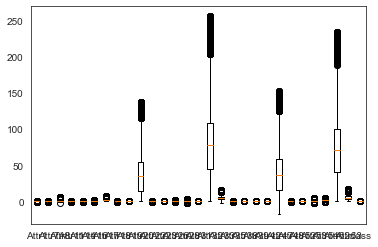

In [31]:
plt.boxplot(df_positive_relation, labels =df_positive_relation.columns)
plt.show()

In [32]:
#sns.pairplot(df_positive_relation, hue = 'class')

In [33]:
#variance inflation factor，VIF
def check_vif(df):
    df = df.drop(['class'], axis=1)  # delete redundant variable
    df['const'] = 1  # must add const, it is important
    x = np.array(df)
    vif_list = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    df_vif = pd.DataFrame({'variable': list(df.columns), 'vif': vif_list})
    df_vif = df_vif[~(df_vif['variable'] == 'const')]   # delet row which belongs to const
    return df_vif

In [34]:
df_postive_vif_check = check_vif(df_positive_relation)
vif_check_attr = df_postive_vif_check[df_postive_vif_check['vif']<5]
vif_attr = []
for i in df_positive_relation.columns:
    for m, n in enumerate(vif_check_attr['variable']):
        if(i == n):
            vif_attr.append(n)

vif_check_attr

,variable,vif
9,Attr20,3.921425
14,Attr31,4.884769
16,Attr33,4.556982
18,Attr38,1.832614
21,Attr47,3.898034
22,Attr48,4.910029
26,Attr62,4.557964
27,Attr63,4.824709


A value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model. In this case, the coefficient estimates and p-values in the regression output are likely unreliable
[Referance](https://www.investopedia.com/terms/v/variance-inflation-factor.asp)

In [35]:
# Get new df_positive_relation filter by VIF
vif_attr.append('class')
df_positive_tmp = df_positive_relation.loc[:, vif_attr]
df_positive_relation = df_positive_tmp.copy()
df_positive_relation.describe()

,Attr20,Attr31,Attr33,Attr38,Attr47,Attr48,Attr62,Attr63,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,38.372294,0.048425,5.105789,0.606513,41.461255,0.023854,76.002341,5.591249,0.047129
std,30.753406,0.066017,3.268745,0.232288,33.831308,0.105885,47.500465,3.548280,0.211926
min,-0.001439,-0.138510,-1.921900,-0.115510,-17.303000,-0.273230,0.000000,-0.000156,0.000000
25%,14.400500,0.013652,2.789700,0.457290,15.148500,-0.028060,40.938500,3.064050,0.000000
50%,34.430750,0.039689,4.680900,0.628750,37.104000,0.009653,70.664000,5.139200,0.000000
75%,54.806500,0.080569,6.608200,0.787865,58.984500,0.078188,100.115000,7.257550,0.000000
max,137.690000,0.241490,16.021000,1.000000,152.000000,0.324830,234.360000,17.588000,1.000000


In [36]:
correlation_group(corr_2 , 0.80)

Attr1   Attr1     1.000000
        Attr7     0.914111
        Attr11    0.850580
        Attr14    0.914053
        Attr18    0.914074
Attr2   Attr2     1.000000
        Attr10   -0.979433
Attr3   Attr3     1.000000
Attr4   Attr4     1.000000
Attr5   Attr5     1.000000
Attr6   Attr6     1.000000
Attr7   Attr1     0.914111
        Attr7     1.000000
        Attr11    0.898072
        Attr14    0.999949
        Attr18    0.999968
        Attr22    0.819075
Attr8   Attr8     1.000000
        Attr17    0.964776
Attr9   Attr9     1.000000
Attr10  Attr2    -0.979433
        Attr10    1.000000
Attr11  Attr1     0.850580
        Attr7     0.898072
        Attr11    1.000000
        Attr14    0.898008
        Attr18    0.898029
        Attr22    0.843273
Attr12  Attr12    1.000000
Attr13  Attr13    1.000000
Attr14  Attr1     0.914053
        Attr7     0.999949
        Attr11    0.898008
        Attr14    1.000000
        Attr18    0.999998
        Attr22    0.819027
Attr15  Attr15    1.000000
A

In [37]:
# Create new data frame with variables having high negative correlation
df_negative_relation = df_median_imputed[['Attr2','Attr10','Attr38','Attr51','Attr56', 'Attr58', 'class']]
df_negative_relation.describe().round(3)

,Attr2,Attr10,Attr38,Attr51,Attr56,Attr58,class
count,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000,10503.000
mean,0.472,0.512,0.607,0.355,0.061,0.944,0.047
std,0.271,0.269,0.232,0.225,0.086,0.082,0.212
min,0.000,-0.345,-0.116,0.000,-0.182,0.695,0.000
25%,0.254,0.323,0.457,0.177,0.014,0.905,0.000
50%,0.464,0.516,0.629,0.327,0.052,0.953,0.000
75%,0.662,0.725,0.788,0.493,0.100,0.989,0.000
max,1.342,1.000,1.000,1.044,0.317,1.176,1.000


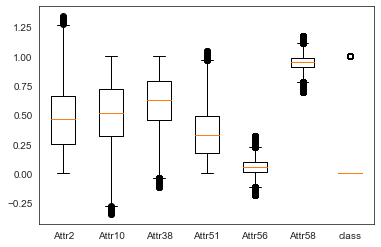

In [38]:
plt.boxplot(df_negative_relation, labels = df_negative_relation.columns )
plt.show()

In [39]:
#sns.pairplot(df_negative_relation, hue = 'class')

In [40]:
df_negtive_vif_check = check_vif(df_negative_relation)
vif_check_attr = df_negtive_vif_check[df_negtive_vif_check['vif']<5]
vif_attr = []
for i in df_negative_relation.columns:
    for m, n in enumerate(vif_check_attr['variable']):
        if(i == n):
            vif_attr.append(n)

vif_check_attr

,variable,vif
4,Attr56,4.107345
5,Attr58,4.160539


In [41]:
# Get new df_negative_relation filter by VIF
df_negative_tmp = df_negative_relation.loc[:, vif_attr]
df_negative_relation = df_negative_tmp.copy()
df_negative_relation.describe()

,Attr56,Attr58
count,10503.000000,10503.000000
mean,0.060608,0.943554
std,0.085776,0.082487
min,-0.181850,0.695110
25%,0.014337,0.905130
50%,0.051765,0.953060
75%,0.100160,0.988805
max,0.317230,1.176400


In [42]:
#combine df_negative_relation and df_positive_relation as a final datafram
df_final_relation = pd.concat([df_negative_relation, df_positive_relation], axis = 1)
df_final_relation.describe().round(5)

,Attr56,Attr58,Attr20,Attr31,Attr33,Attr38,Attr47,Attr48,Attr62,Attr63,class
count,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000,10503.00000
mean,0.06061,0.94355,38.37229,0.04843,5.10579,0.60651,41.46126,0.02385,76.00234,5.59125,0.04713
std,0.08578,0.08249,30.75341,0.06602,3.26874,0.23229,33.83131,0.10589,47.50046,3.54828,0.21193
min,-0.18185,0.69511,-0.00144,-0.13851,-1.92190,-0.11551,-17.30300,-0.27323,0.00000,-0.00016,0.00000
25%,0.01434,0.90513,14.40050,0.01365,2.78970,0.45729,15.14850,-0.02806,40.93850,3.06405,0.00000
50%,0.05176,0.95306,34.43075,0.03969,4.68090,0.62875,37.10400,0.00965,70.66400,5.13920,0.00000
75%,0.10016,0.98880,54.80650,0.08057,6.60820,0.78786,58.98450,0.07819,100.11500,7.25755,0.00000
max,0.31723,1.17640,137.69000,0.24149,16.02100,1.00000,152.00000,0.32483,234.36000,17.58800,1.00000


### Spilt Training set & Testing set *

In [43]:
x = df_final_relation.iloc[:, 0: len(df_final_relation.columns)-1]
y = df_final_relation.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### SMOTE Method*

In [44]:
x_res, y_res = SMOTE(random_state=42, k_neighbors=10).fit_resample(x_train, y_train) # lets reduce the imbalance 

You should split the testing and training sets first, and then over-sampling or under-sampling the training set. This is because the goal of re-sampling is to make the model discriminate, rather than let the model learn the wrong samples. If you resample first before segmenting, it is possible that your testing set and the original data with deviate performance, causing the model to learn a lot of noise.

## Building Classification Models

### Logistic Regression classifier

In [77]:
# Logistic Regression classifier
lr_classifier = LogisticRegression(penalty = 'l2', random_state = 42)

### Support Vector Machine classifier

In [78]:
# SVM classifier
svm_classifier = SVC(kernel = 'poly', C = 5, degree = 5, random_state = 42)

### Random Forest classifier

In [79]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy', random_state = 42)

### Gradient Boosting Tree

In [80]:
# Gradient Boosting Tree Classifier
gbt_classifier = GradientBoostingClassifier(n_estimators = 18, random_state = 42)

### XG Boost

In [81]:
# XGBoost Classifier
XGB_classifier = XGBClassifier(objective='binary:hinge', n_estimators=20, learning_rate= 0.08, eval_metric='error', random_state = 42)

### Model Creator

In [82]:
# creating a dictionary of models
models_dictionary = {}

models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['SVM'] = svm_classifier
models_dictionary['Random Forest'] = rf_classifier    
models_dictionary['Gradient Boosting Tree'] = gbt_classifier
models_dictionary['XG Boost'] = XGB_classifier

In [83]:
# K-Fold Cross Validation
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
        
    return X_train, y_train, X_test, y_test

In [84]:
def training_predict(_models_, ori_x, ori_y, k_folds=10, verbose=False):
    
    # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
    # for train and test sets respectively.
    # The number of items in the list is equal to k_folds
    X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, 
                                                                                 ori_x, 
                                                                                 ori_y, verbose)
    metrics_results = {} # Initializing a Dictionary to store evaluation metrics
    accuracy_list = np.zeros([k_folds])
    precision_list = np.zeros([k_folds,2])
    recall_list = np.zeros([k_folds,2])
    TN_list = np.zeros([k_folds])
    FP_list = np.zeros([k_folds])
    FN_list = np.zeros([k_folds])
    TP_list = np.zeros([k_folds])
    f1_score_list = np.zeros([k_folds])
    
    # Iterate over all the k-folds
    for k_index in range(k_folds):
        
        _X_train = X_train_list[k_index]
        _y_train = y_train_list[k_index]
        _X_test = X_test_list[k_index]
        _y_test = y_test_list[k_index]
    
        #SMOTE
        '''
        You should split the testing and training sets first, and then over-sampling or under-sampling the training set. 
        This is because the goal of re-sampling is to make the model discriminate, 
        rather than let the model learn the wrong samples. 
        If you resample first before segmenting, it is possible that your testing set and the original data with deviate performance, causing the model to learn a lot of noise
        '''
        X_train_oversampled, y_train_oversampled = SMOTE(random_state=42, k_neighbors=10).fit_resample(_X_train, _y_train)
    
        _models_.fit(X_train_oversampled, y_train_oversampled)  # Training
        Y_pred = _models_.predict(_X_test) # Predicts

        #code for calculating accuracy 
        #_accuracy_ = accuracy_score(_y_test, Y_pred, normalize=True)
        _accuracy_ = _models_.score(_X_test, _y_test)
        accuracy_list[k_index] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(_y_test, Y_pred)
        recall_list[k_index] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(_y_test, Y_pred)
        precision_list[k_index] = _precisions_
        
        #code for calculating confusion matrix 
        #Returns an array of the form
        # [[True-negative    False-positive]
        # [False-negative    True-positive]]
        _confusion_matrix_ = confusion_matrix(_y_test, Y_pred)
        TN_list[k_index] = _confusion_matrix_[0][0]
        FP_list[k_index] = _confusion_matrix_[0][1]
        FN_list[k_index] = _confusion_matrix_[1][0]
        TP_list[k_index] = _confusion_matrix_[1][1]
        
        #code for f1-score calculating
        _f1_score_ = f1_score(_y_test, Y_pred)
        f1_score_list[k_index] = _f1_score_
        
        
    # creating a metrics dictionary
    metrics_results['Accuracy'] = np.mean(accuracy_list)
    metrics_results['Precisions'] = np.mean(precision_list, axis=0)
    metrics_results['Recalls'] = np.mean(recall_list, axis=0)
    metrics_results['TN'] = np.mean(TN_list)
    metrics_results['FP'] = np.mean(FP_list)
    metrics_results['FN'] = np.mean(FN_list)
    metrics_results['TP'] = np.mean(TP_list)
    metrics_results['f1-score'] = np.mean(f1_score_list)
    
    if verbose:
        print('\t\t\tAccuracy:', metrics_results['Accuracy'])
        print('\t\t\tPrecision:', metrics_results['Precisions'])
        print('\t\t\tRecall:', metrics_results['Recalls'])
    
    return metrics_results

In [85]:
predictors = {} # Initializing a dictionary to store training and testing data
for model_name, clf in models_dictionary.items():
    predictors[model_name] = {}
    predictors[model_name] =  training_predict(clf, x, y) # metrics_results that is returned from trainer goes to
                                                                  # the respective predictor

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Kun\miniconda3\envs\rwth_py38\lib\site-packages\xgboost

In [86]:
predictors['Logistic Regression']

{'Accuracy': 0.6259186262516423,
 'Precisions': array([0.08057971, 0.08057971]),
 'Recalls': array([0.67071188, 0.67071188]),
 'TN': 624.4,
 'FP': 376.4,
 'FN': 16.5,
 'TP': 33.0,
 'f1-score': 0.14361404395492924}

In [87]:
predictors['SVM']

{'Accuracy': 0.8230020388745413,
 'Precisions': array([0.10072518, 0.10072518]),
 'Recalls': array([0.34598372, 0.34598372]),
 'TN': 847.3,
 'FP': 153.5,
 'FN': 32.4,
 'TP': 17.1,
 'f1-score': 0.15539556815404162}

In [88]:
predictors['Random Forest']

{'Accuracy': 0.865658284626886,
 'Precisions': array([0.09859673, 0.09859673]),
 'Recalls': array([0.22534159, 0.22534159]),
 'TN': 898.0,
 'FP': 102.8,
 'FN': 38.3,
 'TP': 11.2,
 'f1-score': 0.13633863499783988}

In [89]:
predictors['Gradient Boosting Tree']

{'Accuracy': 0.6231574464229079,
 'Precisions': array([0.07681228, 0.07681228]),
 'Recalls': array([0.63823836, 0.63823836]),
 'TN': 623.0,
 'FP': 377.8,
 'FN': 18.0,
 'TP': 31.5,
 'f1-score': 0.13686069444620974}

In [90]:
predictors['XG Boost']

{'Accuracy': 0.4702447555615967,
 'Precisions': array([0.06396496, 0.06396496]),
 'Recalls': array([0.75333613, 0.75333613]),
 'TN': 456.7,
 'FP': 544.1,
 'FN': 12.3,
 'TP': 37.2,
 'f1-score': 0.11775743968862724}

In [92]:
final_report = pd.DataFrame(
    [[predictors['Logistic Regression']['Accuracy'], predictors['Logistic Regression']['Precisions'][0], predictors['Logistic Regression']['Recalls'][0], predictors['Logistic Regression']['f1-score']],
     [predictors['SVM']['Accuracy'], predictors['SVM']['Precisions'][0], predictors['SVM']['Recalls'][0], predictors['SVM']['f1-score']],
     [predictors['Random Forest']['Accuracy'], predictors['Random Forest']['Precisions'][0], predictors['Random Forest']['Recalls'][0], predictors['Random Forest']['f1-score']],
     [predictors['Gradient Boosting Tree']['Accuracy'], predictors['Gradient Boosting Tree']['Precisions'][0], predictors['Gradient Boosting Tree']['Recalls'][0], predictors['Gradient Boosting Tree']['f1-score']],
     [predictors['XG Boost']['Accuracy'], predictors['XG Boost']['Precisions'][0], predictors['XG Boost']['Recalls'][0], predictors['XG Boost']['f1-score']]],
     columns=['accuracy', 'precision', 'recall', 'f1'], 
     index=['lr', 'svm', 'rf', 'gbt', 'xgb'])

print("Model Comparison Report:\n", final_report)
    

Model Comparison Report:
      accuracy  precision    recall        f1
lr   0.625919   0.080580  0.670712  0.143614
svm  0.823002   0.100725  0.345984  0.155396
rf   0.865658   0.098597  0.225342  0.136339
gbt  0.623157   0.076812  0.638238  0.136861
xgb  0.470245   0.063965  0.753336  0.117757
